In [130]:

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Dropout, LSTM, GRU, Conv1D, MaxPooling2D, Flatten
from tensorflow.keras.layers import RepeatVector, TimeDistributed
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks  import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split


### Chargez les données

In [5]:
data = pd.read_csv(r"D:\Nouveau dossier\TitreRNCP_Bloc1\projet_prevision_energies_bloc5\datasets\data.csv", 
                   parse_dates=[0], index_col=0)

data.head()

,temp,SOLAR,BIOMASS,WIND_ONSHORE,NUCLEAR,consommation_totale
timestamp,,,,,,
2020-01-01 00:00:00,0.8,0.0,348.0,2810.0,49462.0,63191.75
2020-01-01 01:00:00,-0.7,0.0,347.0,2655.0,49565.0,61903.75
2020-01-01 02:00:00,-0.3,0.0,348.0,2736.0,49580.0,58716.00
2020-01-01 03:00:00,0.0,0.0,348.0,2631.0,49271.0,56448.25
2020-01-01 04:00:00,0.3,0.0,347.0,2533.0,49438.0,55891.00


In [6]:
data.isnull().sum()

temp                   0
SOLAR                  0
BIOMASS                0
WIND_ONSHORE           0
NUCLEAR                0
consommation_totale    0
dtype: int64

In [9]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [181]:
def window_generator(data, lookback, horizon):
    
    X = []
    y = []
    
    for i in range(lookback, len(data) - horizon):
        
        X.append(data[i-lookback:i])
        y.append(data[i:i+horizon])
        
    return np.array(X), np.array(y)


In [ ]:
lookback = 24
horizon = 1

X, y = window_generator(data_scaled, lookback, horizon)
X.shape, y.shape


((50087, 24, 6), (50087, 1, 6))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=False, random_state=42)
X_train.shape, X_valid.shape, X_test.shape

((36062, 24, 6), (4007, 24, 6), (10018, 24, 6))

In [33]:
y_train = y_train.reshape(-1, y_train.shape[2])
y_valid = y_valid.reshape(-1, y_valid.shape[2])
y_test = y_test.reshape(-1, y_test.shape[2])

y_train.shape, y_valid.shape, y_test.shape

((36062, 6), (4007, 6), (10018, 6))

In [45]:
def create_model(neural_network_type,
                 n_units, X_train, 
                 y_train, 
                 X_valid, 
                 y_valid, 
                 epochs,
                 batch_size,
                 show_losses_plot=False):
        
        
    type_model = { "RNN": SimpleRNN,
            "lstm": LSTM,
            "gru":GRU}
        
    if neural_network_type not in  ["RNN", "lstm", "gru"]:
        raise ValueError("Please select one of these three recurrent neural network models [“RNN”, “lstm”, “gru”].")
        
    model = Sequential()
    model.add(type_model[neural_network_type](units=n_units, return_sequences=True,
                                              activation="relu", input_shape=X_train.shape[1:]))
    model.add(type_model[neural_network_type](units=n_units, return_sequences=True, activation="relu"))
    model.add(type_model[neural_network_type](units=n_units, return_sequences=False, activation="relu"))
    model.add(Dense(units=y_train.shape[1], activation="linear"))
    
    model_ckp = ModelCheckpoint(filepath="best_model.h5", monitor="val_loss", mode="min", save_best_only=True)
    stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
        
        
    model.compile(optimizer="adam", loss="mae")
    
    history = model.fit(x=X_train, y=y_train, validation_data=(X_valid, y_valid), epochs=epochs, 
                       batch_size=batch_size, callbacks=[stop])
    
    
    if show_losses_plot == True:
            
        plt.figure(figsize=(10,6))
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.ylabel("loss")
        plt.xlabel('epochs')
        plt.legend(['training loss', 'validation loss'], loc='upper left')
    
    return model


#### RNN

Epoch 1/100


c:\Users\saida\anaconda3\envs\venv-stat\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


564/564 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0232 - val_loss: 0.0168
Epoch 2/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 3/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0095 - val_loss: 0.0115
Epoch 4/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0088 - val_loss: 0.0123
Epoch 5/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0084 - val_loss: 0.0098
Epoch 6/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0080 - val_loss: 0.0105
Epoch 7/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0079 - val_loss: 0.0095
Epoch 8/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0077 - val_loss: 0.0092
Epoch 9/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0076 - val_loss: 0.0104
Epoch 10/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0075 - val_loss: 0.0095
Epoch 11/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0072 - val_loss: 0.0092
Epoch 12/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step

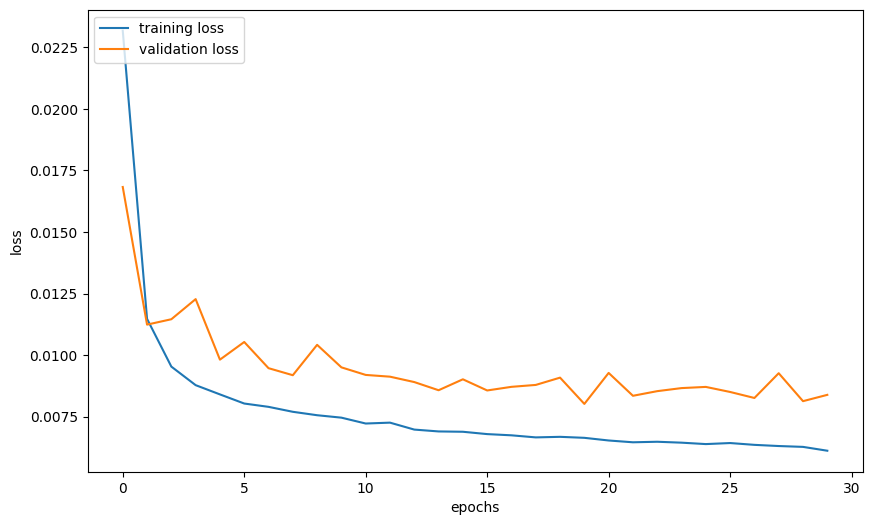

In [46]:
model = create_model(neural_network_type="RNN",
                      n_units=100,
                      X_train=X_train,
                      y_train=y_train,
                      X_valid=X_valid,
                      y_valid=y_valid,
                      epochs=100,
                      batch_size=64,
                      show_losses_plot=True)

In [47]:
y_pred = model.predict(X_test)
y_pred.shape

314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


(10018, 6)

In [166]:
mae_rnn = mean_absolute_error(y_test, y_pred)
r2_rnn = r2_score(y_test, y_pred)
mse_rnn = mean_squared_error(y_test, y_pred)
mae_rnn, r2_rnn, mse_rnn


(0.011298368370406627, 0.9527309523892472, 0.0004404430907188222)

In [49]:
y_pred_descaled = scaler.inverse_transform(y_pred)
y_test_descaled = scaler.inverse_transform(y_test)


In [266]:
def plot_results(y_pred_descaled, y_test_descaled, rows=5*24, n_col=0, col=0):

    plt.figure(figsize=(10,6))
    plt.plot(y_pred_descaled[:rows, n_col], label="Actual")
    plt.plot(y_test_descaled[:rows, n_col], label="Predicted")
    plt.xlabel("Time")
    plt.ylabel("Energy")
    plt.title(f"Energy {data.columns[col]} Prediction")
    plt.legend()
    plt.show()


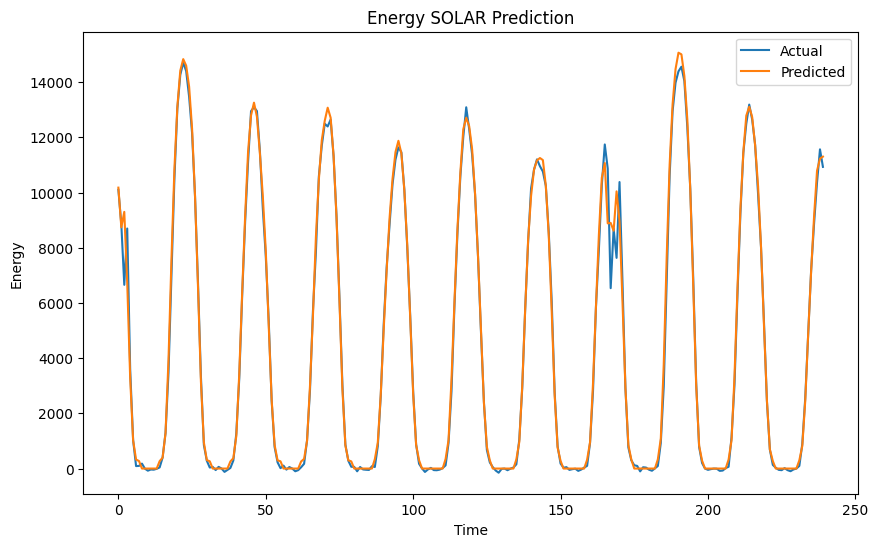

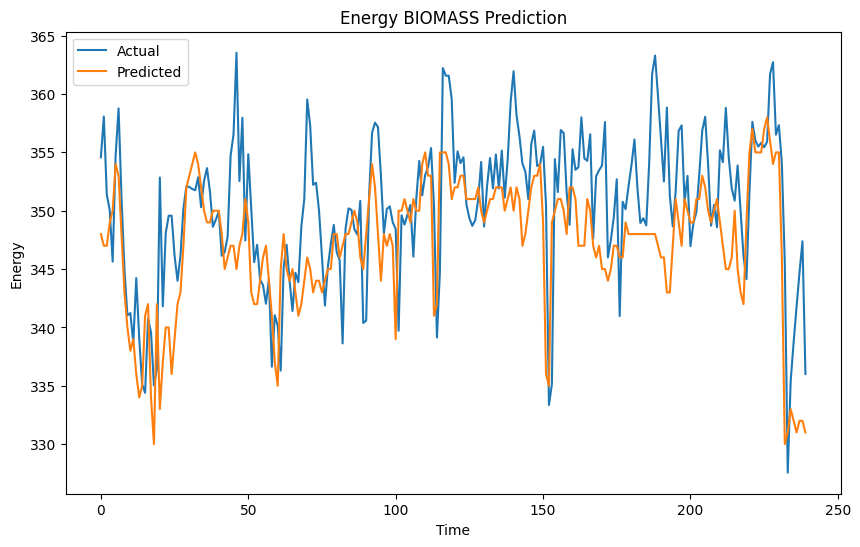

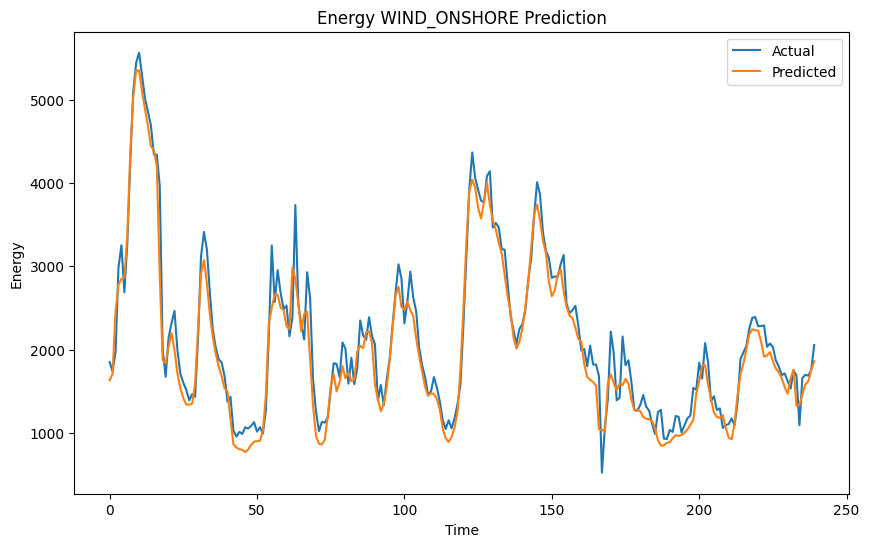

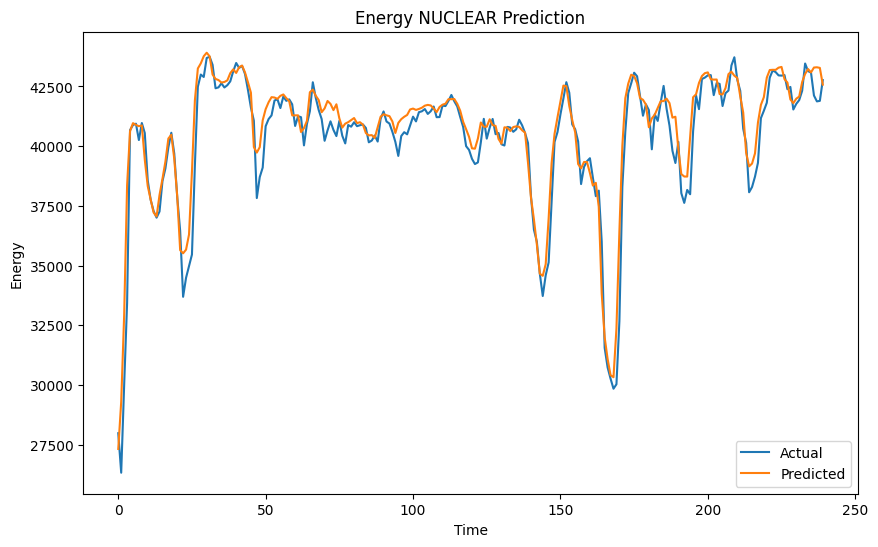

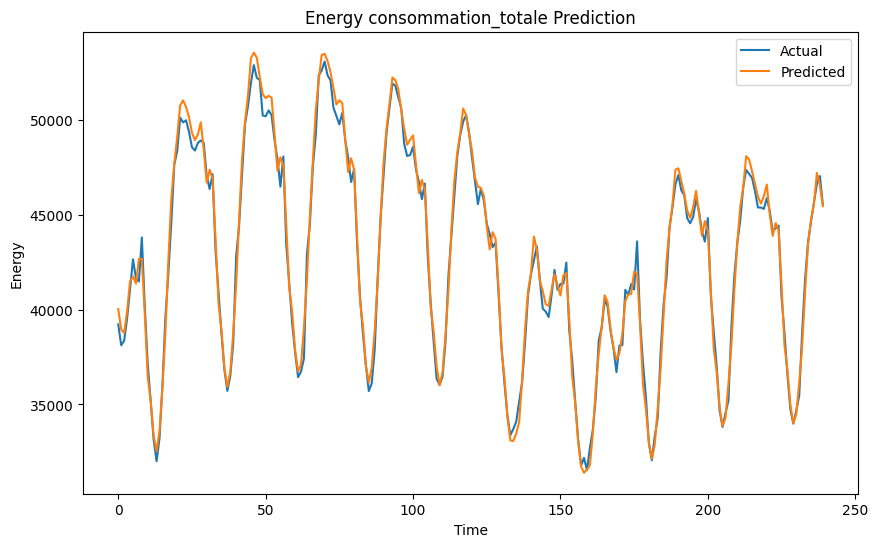

In [267]:
plot_results(y_pred_descaled, y_test_descaled, rows=240, n_col=1, col=1)
plot_results(y_pred_descaled, y_test_descaled, rows=240, n_col=2, col=2)
plot_results(y_pred_descaled, y_test_descaled, rows=240, n_col=3, col=3)
plot_results(y_pred_descaled, y_test_descaled, rows=240, n_col=4, col=4)
plot_results(y_pred_descaled, y_test_descaled, rows=240, n_col=5, col=5)

### LSTM

Epoch 1/100


c:\Users\saida\anaconda3\envs\venv-stat\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


564/564 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.0442 - val_loss: 0.0318
Epoch 2/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 0.0239 - val_loss: 0.0254
Epoch 3/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 0.0196 - val_loss: 0.0241
Epoch 4/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.0172 - val_loss: 0.0200
Epoch 5/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.0153 - val_loss: 0.0183
Epoch 6/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.0141 - val_loss: 0.0159
Epoch 7/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.0127 - val_loss: 0.0149
Epoch 8/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.0117 - val_loss: 0.0136
Epoch 9/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.0112 - val_loss: 0.0126
Epoch 10/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 0.0106 - val_loss: 0.0121
Epoch 11/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.0099 - val_loss: 0.0128
Epoch 12/100
564/564 ━━━━━━━━━━

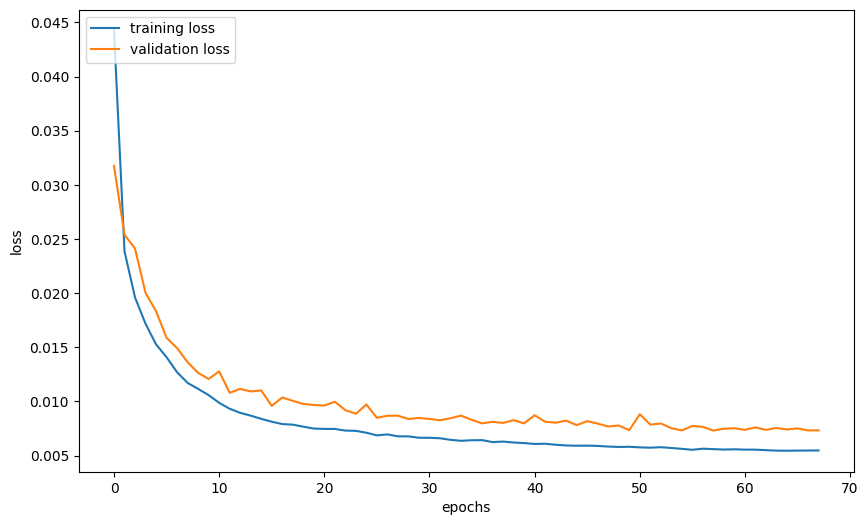

In [57]:
model1 = create_model(neural_network_type="lstm",
                      n_units=100,
                      X_train=X_train,
                      y_train=y_train,
                      X_valid=X_valid,
                      y_valid=y_valid,
                      epochs=100,
                      batch_size=64,
                      show_losses_plot=True)

In [58]:
y_pred_lstm = model1.predict(X_test)
y_pred_lstm.shape


314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


(10018, 6)

In [167]:
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm, r2_lstm, mse_lstm

(0.00950130186455154, 0.9736476399512003, 0.0003174496714334728)

In [61]:
y_pred_lstm_descaled = scaler.inverse_transform(y_pred_lstm)

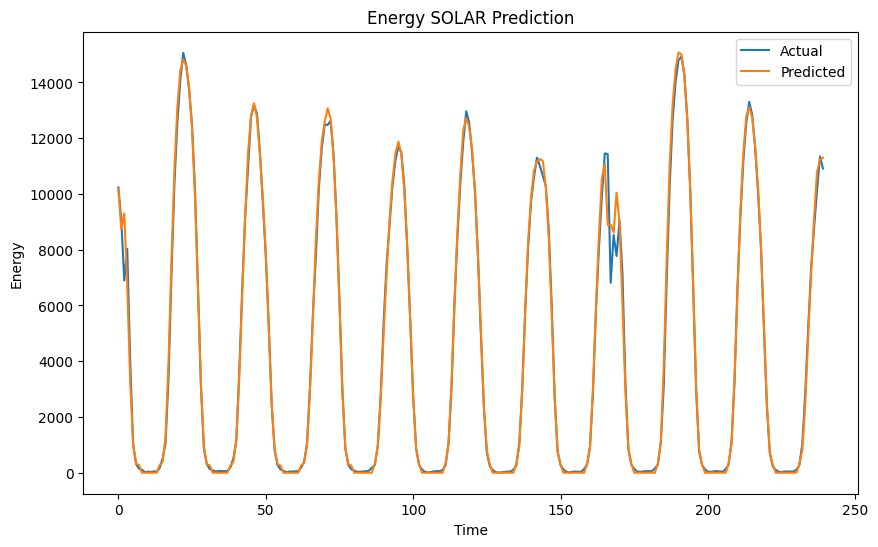

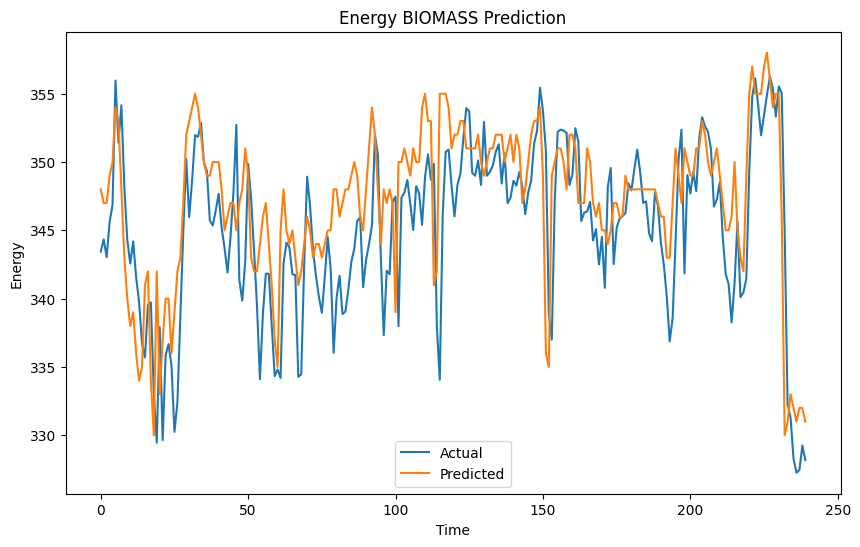

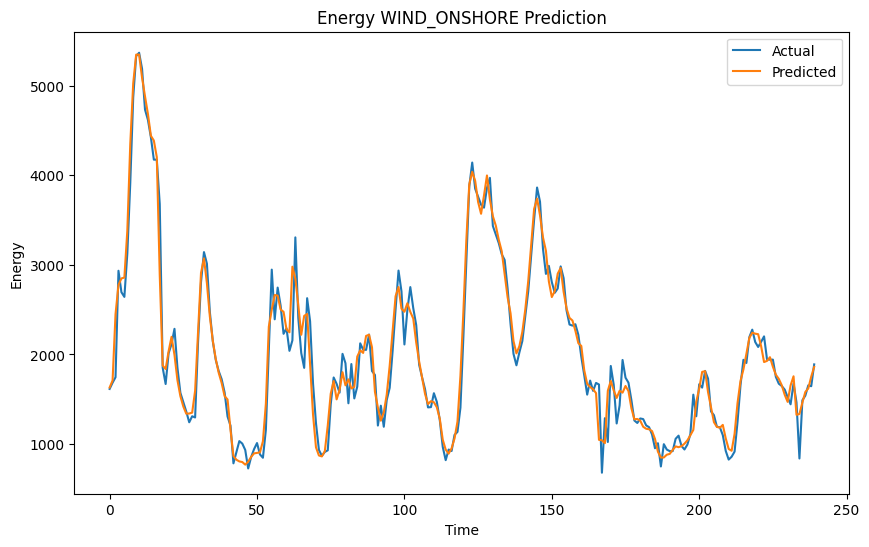

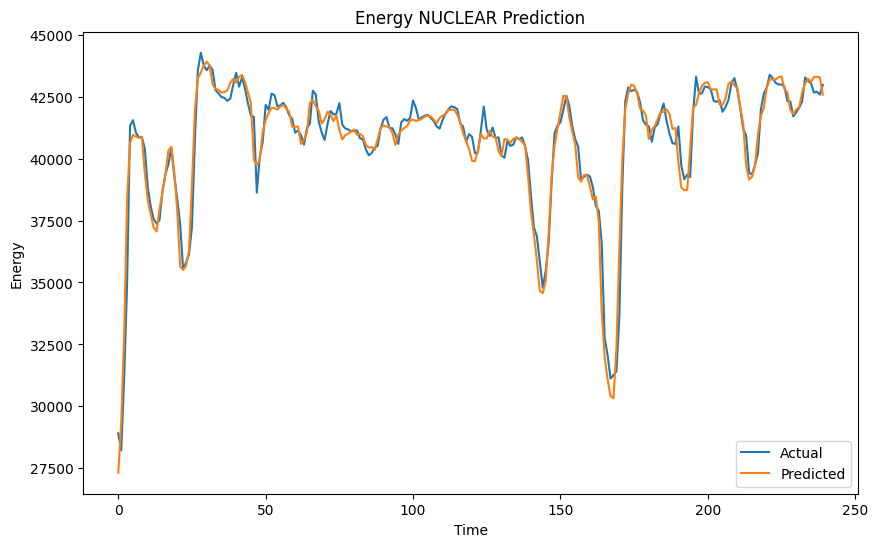

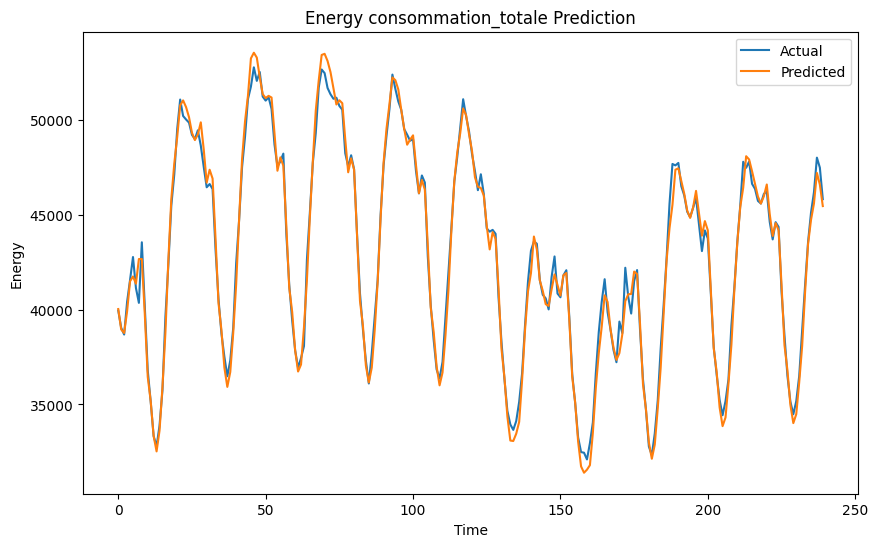

In [268]:
plot_results(y_pred_lstm_descaled, y_test_descaled, rows=240, n_col=1, col=1)
plot_results(y_pred_lstm_descaled, y_test_descaled, rows=240, n_col=2, col=2)
plot_results(y_pred_lstm_descaled, y_test_descaled, rows=240, n_col=3, col=3)
plot_results(y_pred_lstm_descaled, y_test_descaled, rows=240, n_col=4, col=4)
plot_results(y_pred_lstm_descaled, y_test_descaled, rows=240, n_col=5, col=5)

### GRU

c:\Users\saida\anaconda3\envs\venv-stat\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.0326 - val_loss: 0.0168
Epoch 2/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.0115 - val_loss: 0.0140
Epoch 3/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 0.0099 - val_loss: 0.0115
Epoch 4/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - loss: 0.0091 - val_loss: 0.0104
Epoch 5/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - loss: 0.0089 - val_loss: 0.0108
Epoch 6/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.0088 - val_loss: 0.0111
Epoch 7/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.0086 - val_loss: 0.0107
Epoch 8/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.0086 - val_loss: 0.0104
Epoch 9/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.0084 - val_loss: 0.0102
Epoch 10/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.0084 - val_loss: 0.0103
Epoch 11/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.0082 - val_loss: 0.0099
Epoch 12/100
564/56

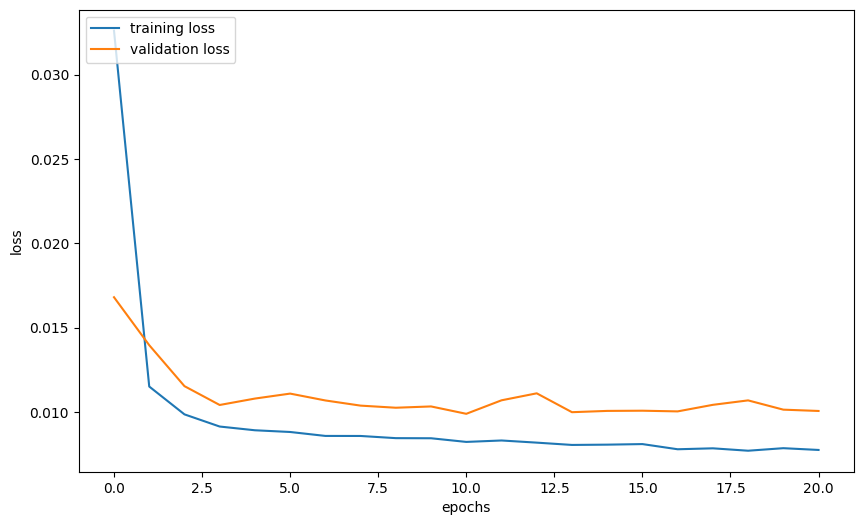

In [63]:
model2 = create_model(neural_network_type="gru",
                      n_units=100,
                      X_train=X_train,
                      y_train=y_train,
                      X_valid=X_valid,
                      y_valid=y_valid,
                      epochs=100,
                      batch_size=64,
                      show_losses_plot=True)



In [64]:
y_pred_gru = model2.predict(X_test)
y_pred_gru.shape

314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


(10018, 6)

In [168]:
mae_gru = mean_absolute_error(y_test, y_pred_gru)
r2_gru = r2_score(y_test, y_pred_gru)
mse_gru = mean_squared_error(y_test, y_pred_gru)
mae_gru, r2_gru, mse_gru

(0.012263104769601922, 0.9624540163798146, 0.0004479306417465453)

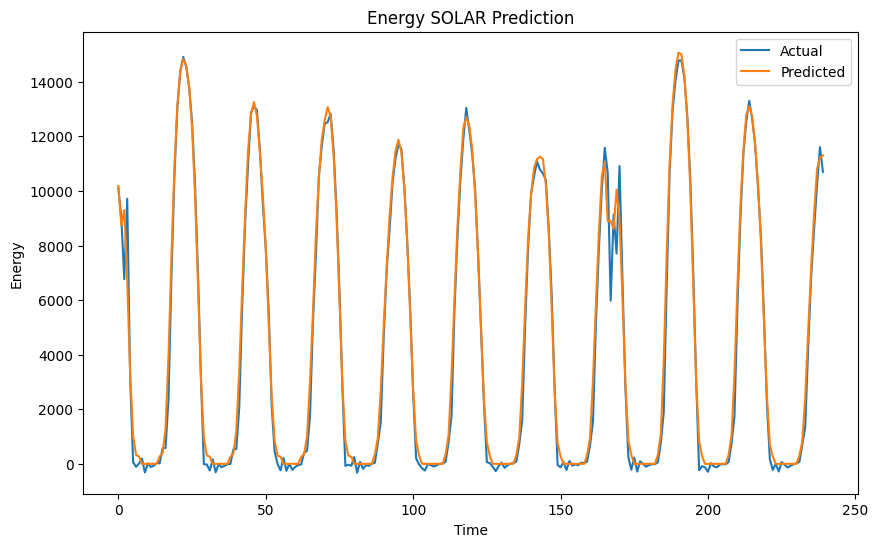

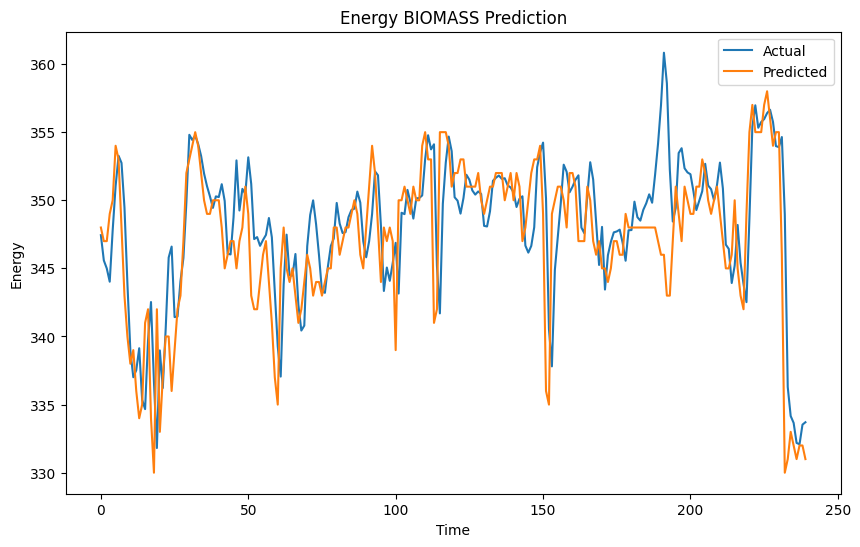

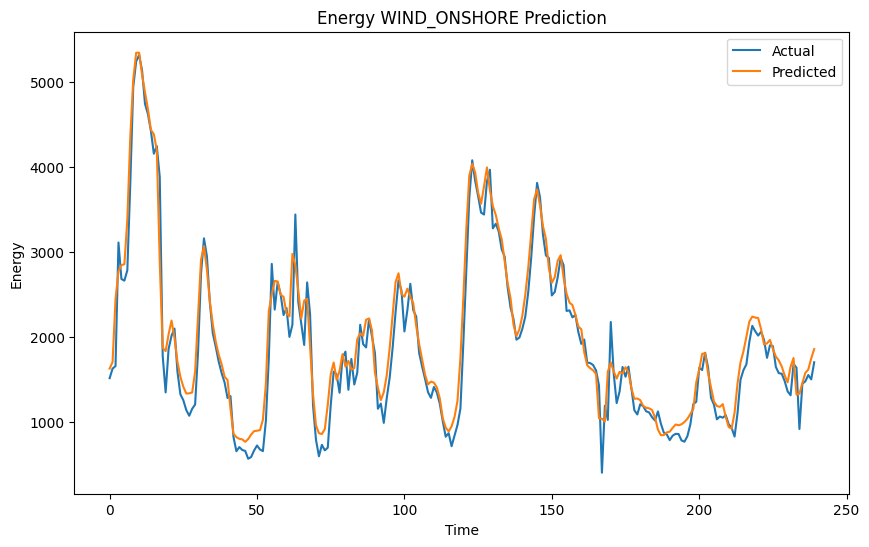

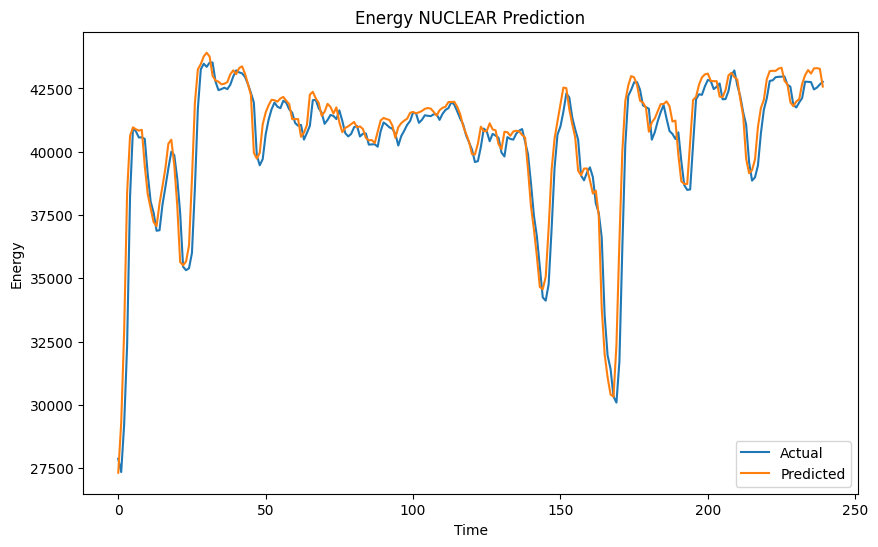

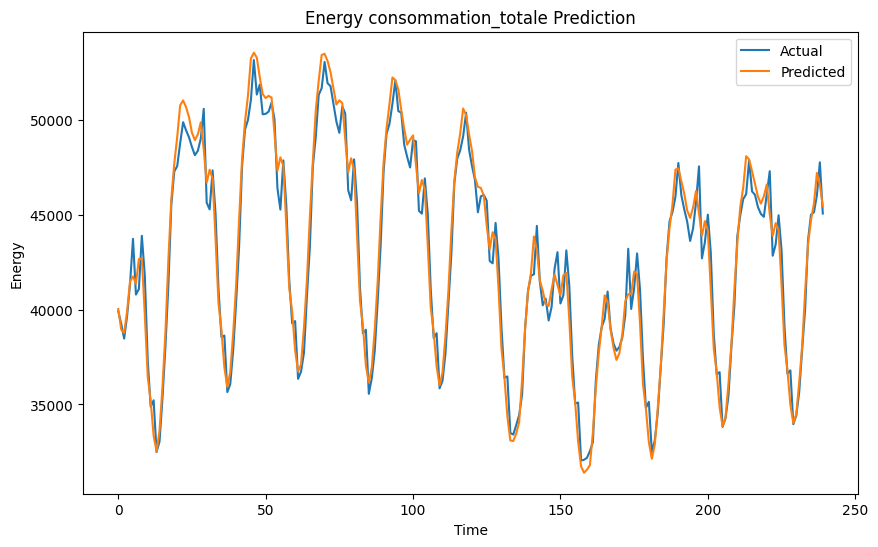

In [269]:
y_pred_gru_descaled = scaler.inverse_transform(y_pred_gru)
plot_results(y_pred_gru_descaled, y_test_descaled, rows=240, n_col=1, col=1)
plot_results(y_pred_gru_descaled, y_test_descaled, rows=240, n_col=2, col=2)
plot_results(y_pred_gru_descaled, y_test_descaled, rows=240, n_col=3, col=3)
plot_results(y_pred_gru_descaled, y_test_descaled, rows=240, n_col=4, col=4)
plot_results(y_pred_gru_descaled, y_test_descaled, rows=240, n_col=5, col=5)

In [270]:
df_metrics = pd.DataFrame({"model": ["RNN", "LSTM", "GRU"],
                            "mae": [mae_rnn, mae_lstm, mae_gru], 
                            "r2": [r2_rnn, r2_lstm, r2_gru],
                            "mse": [mse_rnn, mse_lstm, mse_gru]})
df_metrics


,model,mae,r2,mse
0,RNN,0.011298,0.952731,0.000440
1,LSTM,0.009501,0.973648,0.000317
2,GRU,0.012263,0.962454,0.000448


### Prévision de 48h

### Pévision monovariée (une seule série)

#### Consommation totale et température

In [150]:
data_conso = data[["consommation_totale", "temp"]]

scaler_conso = MinMaxScaler()
data_conso_scaled = scaler_conso.fit_transform(data_conso)

In [ ]:
X_conso = []
y_conso = []

n_futur = 24*2
window_size = 5*24

for i in range(window_size, len(data_conso) - n_futur):
    
    X_conso.append(data_conso_scaled[i-window_size:i])
    y_conso.append(data_conso_scaled[i:i+n_futur, 0])

X_conso = np.array(X_conso)
y_conso = np.array(y_conso)

X_conso.shape, y_conso.shape

((49944, 120, 2), (49944, 48))

In [174]:
X_conso_train, X_conso_test, y_conso_train, y_conso_test = train_test_split(X_conso, y_conso, test_size=0.2, shuffle=False, random_state=42)
X_conso_train, X_conso_valid, y_conso_train, y_conso_valid = train_test_split(X_conso_train, y_conso_train, test_size=0.1, shuffle=False, random_state=42)
X_conso_train.shape, X_conso_valid.shape, X_conso_test.shape


((35959, 120, 2), (3996, 120, 2), (9989, 120, 2))

In [175]:
y_conso_train.shape, y_conso_valid.shape, y_conso_test.shape

((35959, 48), (3996, 48), (9989, 48))

Epoch 1/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - loss: 0.0674 - val_loss: 0.0453
Epoch 2/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 31s 56ms/step - loss: 0.0507 - val_loss: 0.0411
Epoch 3/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 33s 58ms/step - loss: 0.0469 - val_loss: 0.0401
Epoch 4/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 32s 56ms/step - loss: 0.0442 - val_loss: 0.0383
Epoch 5/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 31s 56ms/step - loss: 0.0420 - val_loss: 0.0344
Epoch 6/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 32s 57ms/step - loss: 0.0404 - val_loss: 0.0343
Epoch 7/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 31s 56ms/step - loss: 0.0394 - val_loss: 0.0363
Epoch 8/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 31s 55ms/step - loss: 0.0368 - val_loss: 0.0321
Epoch 9/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 31s 55ms/step - loss: 0.0359 - val_loss: 0.0314
Epoch 10/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 30s 54ms/step - loss: 0.0353 - val_loss: 0.0283
Epoch 11/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - loss: 0.0340 - val_loss: 0.0290
Epoch 12/100
562/56

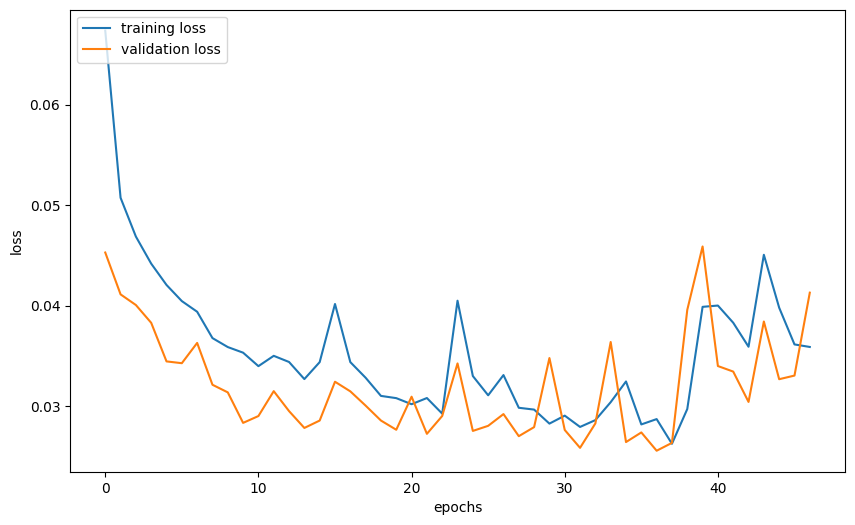

In [159]:
model_conso = create_model(neural_network_type="RNN",
                           n_units=128,
                           X_train=X_conso_train,
                           y_train=y_conso_train,
                           X_valid=X_conso_valid,
                           y_valid=y_conso_valid,
                           epochs=100,
                           batch_size=64,
                           show_losses_plot=True)

In [272]:
y_pred_conso = model_conso.predict(X_conso_test)
y_pred_conso.shape


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


(9989, 48)

In [273]:
y_pred_conso.shape, y_conso_test.shape

((9989, 48), (9989, 48))

In [274]:
mae_conso = mean_absolute_error(y_conso_test, y_pred_conso)
r2_conso = r2_score(y_conso_test, y_pred_conso)
mse_conso = mean_squared_error(y_conso_test, y_pred_conso)
mae_conso, r2_conso, mse_conso


(0.028329975853733504, 0.9404667377318816, 0.0017979891809992864)

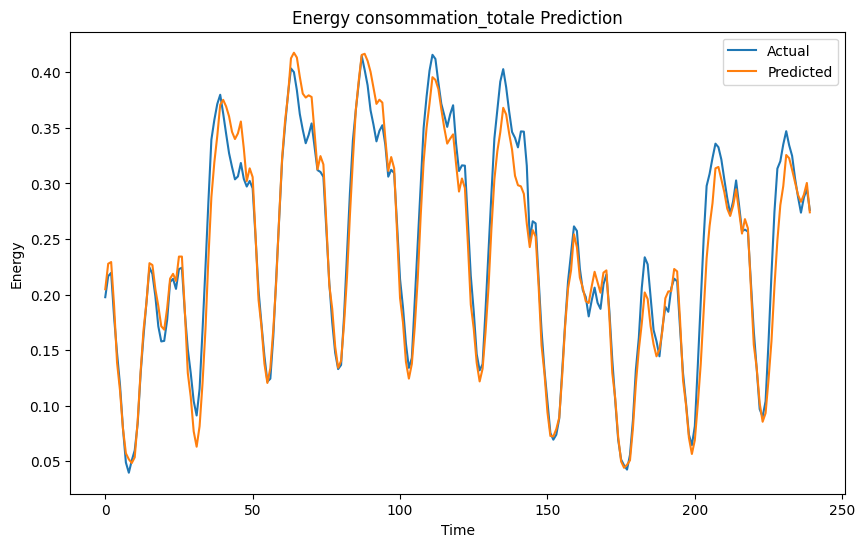

In [275]:
y_pred_conso = y_pred_conso[::48, :].reshape(-1, 1)
y_test_conso = y_conso_test[::48, :].reshape(-1, 1)

plot_results(y_pred_conso, y_test_conso, rows=240, n_col=0, col=5)

#### Solaire et température

In [183]:
data_solaire = data[["SOLAR", "temp"]]

scaler_solaire = MinMaxScaler()
data_solaire_scaled = scaler_solaire.fit_transform(data_solaire)


n_futur = 24*2
window_size = 5*24

X_solaire, y_solaire = window_generator(data_solaire_scaled, window_size, n_futur)
X_solaire.shape, y_solaire.shape

((49944, 120, 2), (49944, 48, 2))

In [230]:
X_solaire_train, X_solaire_test, y_solaire_train, y_solaire_test = train_test_split(X_solaire, y_solaire, test_size=0.2, shuffle=False, random_state=42)
X_solaire_train, X_solaire_valid, y_solaire_train, y_solaire_valid = train_test_split(X_solaire_train, y_solaire_train, test_size=0.1, shuffle=False, random_state=42)
X_solaire_train.shape, X_solaire_valid.shape, X_solaire_test.shape

y_solaire_train.shape, y_solaire_valid.shape, y_solaire_test.shape

((35959, 48, 2), (3996, 48, 2), (9989, 48, 2))

In [231]:
y_solaire_train = y_solaire_train[:, :, 0].reshape(-1, n_futur)
y_solaire_valid = y_solaire_valid[:, :, 0].reshape(-1, n_futur)
y_solaire_test = y_solaire_test[:, :, 0].reshape(-1, n_futur)
y_solaire_train.shape, y_solaire_valid.shape, y_solaire_test.shape

((35959, 48), (3996, 48), (9989, 48))

Epoch 1/100


c:\Users\saida\anaconda3\envs\venv-stat\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


562/562 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - loss: 0.0202 - val_loss: 0.0275
Epoch 2/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - loss: 0.0142 - val_loss: 0.0257
Epoch 3/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - loss: 0.0132 - val_loss: 0.0257
Epoch 4/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - loss: 0.0129 - val_loss: 0.0249
Epoch 5/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - loss: 0.0126 - val_loss: 0.0237
Epoch 6/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - loss: 0.0124 - val_loss: 0.0239
Epoch 7/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - loss: 0.0122 - val_loss: 0.0237
Epoch 8/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - loss: 0.0123 - val_loss: 0.0234
Epoch 9/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - loss: 0.0120 - val_loss: 0.0239
Epoch 10/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 27s 48ms/step - loss: 0.0120 - val_loss: 0.0235
Epoch 11/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 31s 55ms/step - loss: 0.0119 - val_loss: 0.0233
Epoch 12/100
562/562 ━━━━━━━━━━

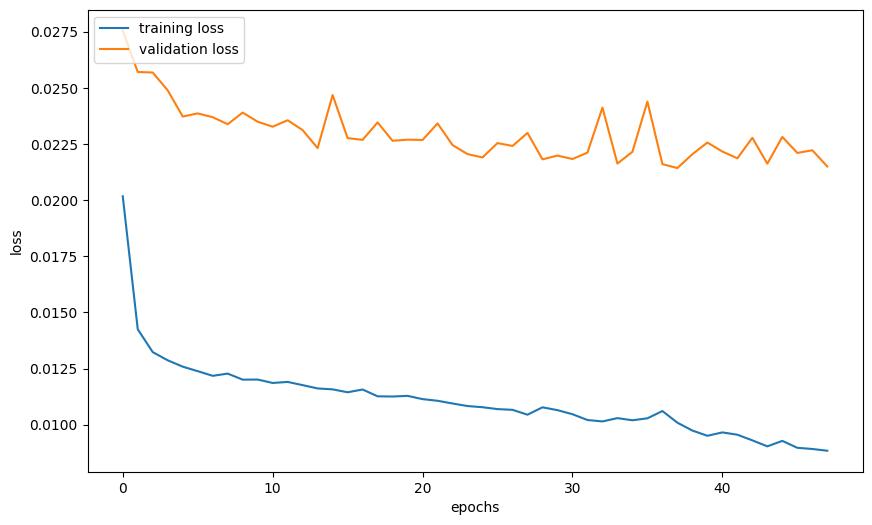

In [187]:
model_solaire = create_model(neural_network_type="RNN",
                              n_units=128,
                              X_train=X_solaire_train,
                              y_train=y_solaire_train,
                              X_valid=X_solaire_valid,
                              y_valid=y_solaire_valid,
                              epochs=100,
                              batch_size=64,
                              show_losses_plot=True)

In [228]:
y_pred_solaire = model_solaire.predict(X_solaire_test)
y_pred_solaire.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


(9989, 48)

In [232]:
mae_solaire = mean_absolute_error(y_solaire_test, y_pred_solaire)
r2_solaire = r2_score(y_solaire_test, y_pred_solaire)
mse_solaire = mean_squared_error(y_solaire_test, y_pred_solaire)
mae_solaire, r2_solaire, mse_solaire

(0.026200505471387043, 0.8795985518561579, 0.002630660278774464)

In [233]:
y_pred_solaire.shape, y_solaire_test.shape

((9989, 48), (9989, 48))

In [240]:
y_pred_solaire = y_pred_solaire[::48, :].reshape(-1, 1)
y_test_solaire = y_solaire_test[::48, :].reshape(-1, 1)

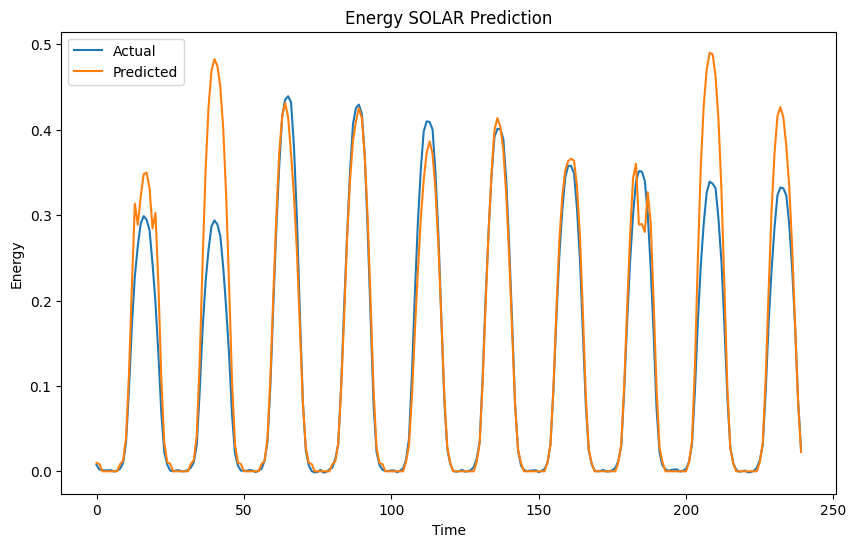

In [276]:
plot_results(y_pred_solaire, y_test_solaire, 240, n_col=0, col=1)

In [205]:
data_biomasse = data[["BIOMASS", "temp"]]

scaler_biomasse = MinMaxScaler()
data_biomasse_scaled = scaler_biomasse.fit_transform(data_biomasse)

X_biomasse, y_biomasse = window_generator(data_biomasse_scaled, window_size, n_futur)
X_biomasse.shape, y_biomasse.shape

((49944, 120, 2), (49944, 48, 2))

In [293]:
X_biomasse_train, X_biomasse_test, y_biomasse_train, y_biomasse_test = train_test_split(X_biomasse, y_biomasse, test_size=0.2, shuffle=False, random_state=42)
X_biomasse_train, X_biomasse_valid, y_biomasse_train, y_biomasse_valid = train_test_split(X_biomasse_train, y_biomasse_train, test_size=0.1, shuffle=False, random_state=42)
X_biomasse_train.shape, X_biomasse_valid.shape, X_biomasse_test.shape

((35959, 120, 2), (3996, 120, 2), (9989, 120, 2))

In [294]:
y_biomasse_train = y_biomasse_train[:, :, 0].reshape(-1, n_futur)
y_biomasse_valid = y_biomasse_valid[:, :, 0].reshape(-1, n_futur)
y_biomasse_test = y_biomasse_test[:, :, 0].reshape(-1, n_futur)
y_biomasse_train.shape, y_biomasse_valid.shape, y_biomasse_test.shape

((35959, 48), (3996, 48), (9989, 48))

Epoch 1/100


c:\Users\saida\anaconda3\envs\venv-stat\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


562/562 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - loss: 0.0132 - val_loss: 0.0039
Epoch 2/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 28s 49ms/step - loss: 0.0091 - val_loss: 0.0042
Epoch 3/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - loss: 0.0089 - val_loss: 0.0042
Epoch 4/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - loss: 0.0084 - val_loss: 0.0041
Epoch 5/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - loss: 0.0085 - val_loss: 0.0035
Epoch 6/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - loss: 0.0083 - val_loss: 0.0035
Epoch 7/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - loss: 0.0082 - val_loss: 0.0059
Epoch 8/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - loss: 0.0083 - val_loss: 0.0034
Epoch 9/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 30s 54ms/step - loss: 0.0082 - val_loss: 0.0034
Epoch 10/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - loss: 0.0081 - val_loss: 0.0037
Epoch 11/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 28s 49ms/step - loss: 0.0081 - val_loss: 0.0034
Epoch 12/100
562/562 ━━━━━━━━━━

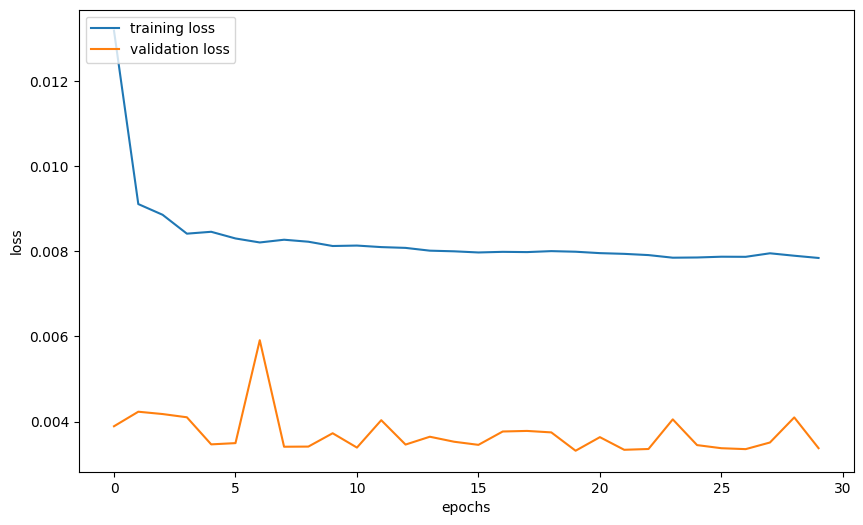

In [208]:
model_biomasse = create_model(neural_network_type="RNN",
                              n_units=128,
                              X_train=X_biomasse_train,
                              y_train=y_biomasse_train,
                              X_valid=X_biomasse_valid,
                              y_valid=y_biomasse_valid,
                              epochs=100,
                              batch_size=64,
                              show_losses_plot=True)

In [290]:
y_pred_biomasse = model_biomasse.predict(X_biomasse_test)
y_pred_biomasse.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


(9989, 48)

In [295]:
mae_biomasse = mean_absolute_error(y_biomasse_test, y_pred_biomasse)
r2_biomasse = r2_score(y_biomasse_test, y_pred_biomasse)
mse_biomasse = mean_squared_error(y_biomasse_test, y_pred_biomasse)
mae_biomasse, r2_biomasse, mse_biomasse

(0.012970981336865648, 0.4808811902368359, 0.0010759889278132435)